# Проект: Определение стоимости автомобилей

<b>Описание проекта</b>
<p>
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
</p>

<b>Цель:</b> 
<p>Требуется построить модель, которая умеет определять рыночную стоимость автомобиля на основе данных о технических характеристиках, комплектации и ценах других автомобилей.</p>
<div>Критерии, которые важны заказчику:</div>
<ul>
    <li>качество предсказания;</li>
    <li>время обучения модели;</li>
    <li>время предсказания модели.</li>
</ul>

<b>Задачи:</b>
<ol>
<li>Построить модели определения рыночной стоимости автомобиля на основе моделей LightGBM и другой модели (не бустинг)</li>
<li>Проанализировать время обучения, время предсказания и качество моделей.</li>
<li>
Опираясь на критерии заказчика,выбратье лучшую модель, проверить её качество на тестовой выборке</li>
</ol>

## Подключение необходимых библиотек

In [2]:
!pip install scikit-learn==1.4 -q
!pip install pandas==1.5.0 -q
!pip install lightgbm -q

import pandas as pd
import os
import platform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats as st

import phik

# загружаем классы для подготовки данных
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# загружаем pipeline, нужные модели и метрики
from numpy.random import RandomState
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from time import time

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 1.1 Загрузка данных

Прочитаем исходные данные из файлов

In [2]:
datasets_path='/datasets/'
if platform.system()=='Windows':
    cwd = os.getcwd()
    datasets_path= os.getcwd()+'\\datasets\\'
autos_data= pd.read_csv(datasets_path+'autos.csv', sep=',', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

##  1.2 Предобработка данных

Выведем общую информацию и первые 5 строк файла autos.csv для контроля загрузки и первого знакомства с данными

In [3]:
print(autos_data.info())
autos_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


#### Анализ и обработка пропусков в данных

Пропуски в данных обнаружены в колонках VehicleType, Gearbox, Model, FuelType, Repaired. Заменим пропуски в колонках на заглушку "not specified" ("не указан")

In [4]:
autos_data['VehicleType']= autos_data['VehicleType'].fillna('not specified')
autos_data['Gearbox']= autos_data['Gearbox'].fillna('not specified')
autos_data['Model']= autos_data['Model'].fillna('not specified')
autos_data['FuelType']= autos_data['FuelType'].fillna('not specified')
autos_data['Repaired']= autos_data['Repaired'].fillna('not specified')
autos_data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

#### Поиск явных дубликатов

In [5]:
autos_data.duplicated().sum()

4

Удалим явные дубликаты

In [6]:
autos_data= autos_data.drop_duplicates()
autos_data.duplicated().sum()

0

**Вывод: явные дубликаты удалены**

#### Поиск неявных дубликатов

In [7]:
autos_data['VehicleType'].unique()

array(['not specified', 'coupe', 'suv', 'small', 'sedan', 'convertible',
       'bus', 'wagon', 'other'], dtype=object)

In [8]:
autos_data['Gearbox'].unique()

array(['manual', 'auto', 'not specified'], dtype=object)

In [9]:
autos_data['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [10]:
autos_data['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [11]:
autos_data['FuelType'].unique()

array(['petrol', 'gasoline', 'not specified', 'lpg', 'other', 'hybrid',
       'cng', 'electric'], dtype=object)

In [12]:
autos_data['Repaired'].unique()

array(['not specified', 'yes', 'no'], dtype=object)

**Вывод: неявные дубликаты не обнаружены**

In [13]:
autos_data['Model']= autos_data['Model'].replace('rangerover','range_rover')
autos_data['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [14]:
autos_data['FuelType']= autos_data['FuelType'].replace('gasoline','petrol')
autos_data['FuelType'].sort_values().unique()

array(['cng', 'electric', 'hybrid', 'lpg', 'not specified', 'other',
       'petrol'], dtype=object)

#### Изучим категориальные признаки

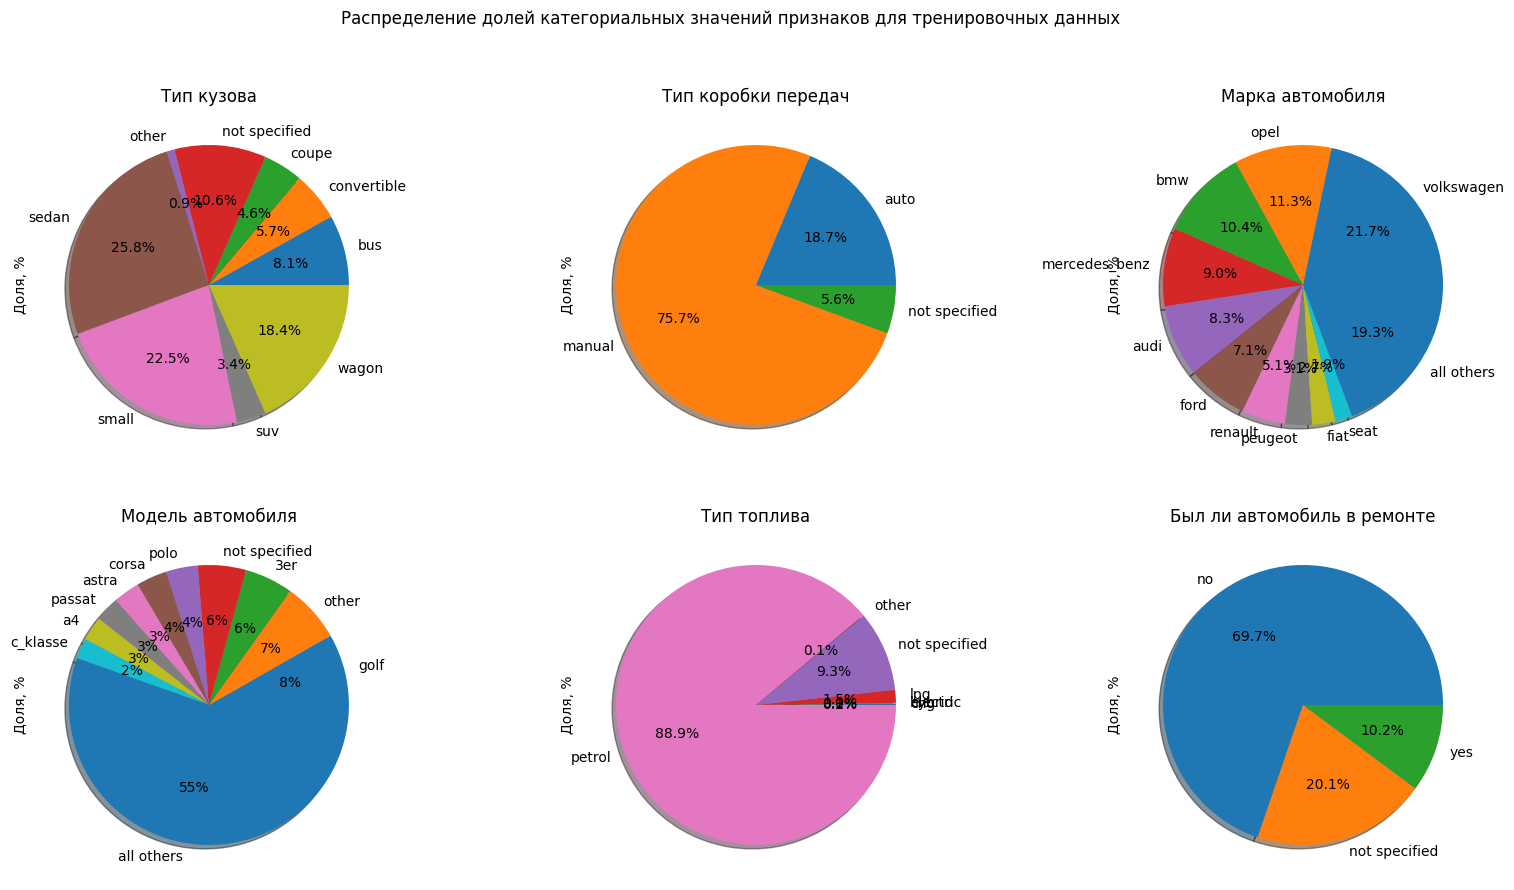

In [15]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('Распределение долей категориальных значений признаков для тренировочных данных')
autos_data.groupby('VehicleType')['VehicleType'].count().plot(
ax=ax1,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Тип кузова')
autos_data.groupby('Gearbox')['Gearbox'].count().plot(
ax=ax2,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Тип коробки передач')
autos_data_top10_brands= autos_data.groupby('Brand')['Brand'].count().sort_values(ascending=False).head(10)
autos_data_top10_brands['all others']= autos_data.groupby('Brand')['Brand'].count().sum()-autos_data_top10_brands.sum()
autos_data_top10_brands.plot(
ax=ax3,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Марка автомобиля')
autos_data_top10_models= autos_data.groupby('Model')['Model'].count().sort_values(ascending=False).head(10)
autos_data_top10_models['all others']= autos_data.groupby('Model')['Model'].count().sum()-autos_data_top10_models.sum()
autos_data_top10_models.plot(
ax=ax4,
kind='pie',
autopct='%1.0f%%', 
shadow=True,
ylabel='Доля, %',
title='Модель автомобиля')
autos_data.groupby('FuelType')['FuelType'].count().plot(
ax=ax5,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Тип топлива')
autos_data.groupby('Repaired')['Repaired'].count().plot(
ax=ax6,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Был ли автомобиль в ремонте')
plt.show()

**Выводы: среди категориальных признаков нет неинформативных (нет признаков, где 1 единственное значение). Данные не сбалансированы, при этом видны значительные пропуски в данных (категории "others" и "not specified")**

#### Изучим числовые характеристики исходных данных 

Преобразуем даты (дата скачивания, дата создания анкеты, дата последней активности пользователя) в числа чтобы можно было анализировать их как числа

In [16]:
def to_ns(x):
    return pd.to_datetime(x).value
autos_data['DateCrawled'] = autos_data['DateCrawled'].apply(to_ns)
autos_data['DateCreated'] = autos_data['DateCreated'].apply(to_ns)
autos_data['LastSeen'] = autos_data['LastSeen'].apply(to_ns)

In [17]:
autos_data.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,3.543650e+05,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,3.543650e+05,354365.0,354365.000000,3.543650e+05
mean,1.458565e+18,4416.679830,2004.234481,110.093816,128211.363989,5.714650,1.458501e+18,0.0,50508.503800,1.459295e+18
std,7.864397e+14,4514.176349,90.228466,189.851330,37905.083858,3.726432,8.109680e+14,0.0,25783.100078,7.933289e+14
min,1.457187e+18,0.000000,1000.000000,0.000000,5000.000000,0.000000,1.394410e+18,0.0,1067.000000,1.457187e+18
25%,1.457870e+18,1050.000000,1999.000000,69.000000,125000.000000,3.000000,1.457827e+18,0.0,30165.000000,1.458701e+18
50%,1.458583e+18,2700.000000,2003.000000,105.000000,150000.000000,6.000000,1.458518e+18,0.0,49413.000000,1.459697e+18
75%,1.459262e+18,6400.000000,2008.000000,143.000000,150000.000000,9.000000,1.459210e+18,0.0,71083.000000,1.459938e+18
max,1.460040e+18,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,1.459987e+18,0.0,99998.000000,1.460041e+18


Количество фотографий автомобиля (NumberOfPictures) похоже не было внесено в базу данных тк все значения =0. Данный признак является не информативным, удалим его. Минимальное значение года регистрации авто=1000, и максимальное = 9999 указывает на ошибки в данных. Минимальное значение месяца регистрации и мощности автомобиля, равное 0, указывает на неполноту данных. Максимальное значение мощности авто= 20000 л.с. вызывает подозрение, что также есть ошибочные данные. Построим ящик с усами для года регистрации и мощности чтобы выяснить, много ли подобных выбросов.

In [18]:
autos_data= autos_data.drop('NumberOfPictures', axis=1)
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  int64 
 1   Price              354365 non-null  int64 
 2   VehicleType        354365 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            354365 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              354365 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           354365 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           354365 non-null  object
 12  DateCreated        354365 non-null  int64 
 13  PostalCode         354365 non-null  int64 
 14  LastSeen           354365 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 43.3+ MB


**Анализ распределения численных значений исходных данных и целевого признака**

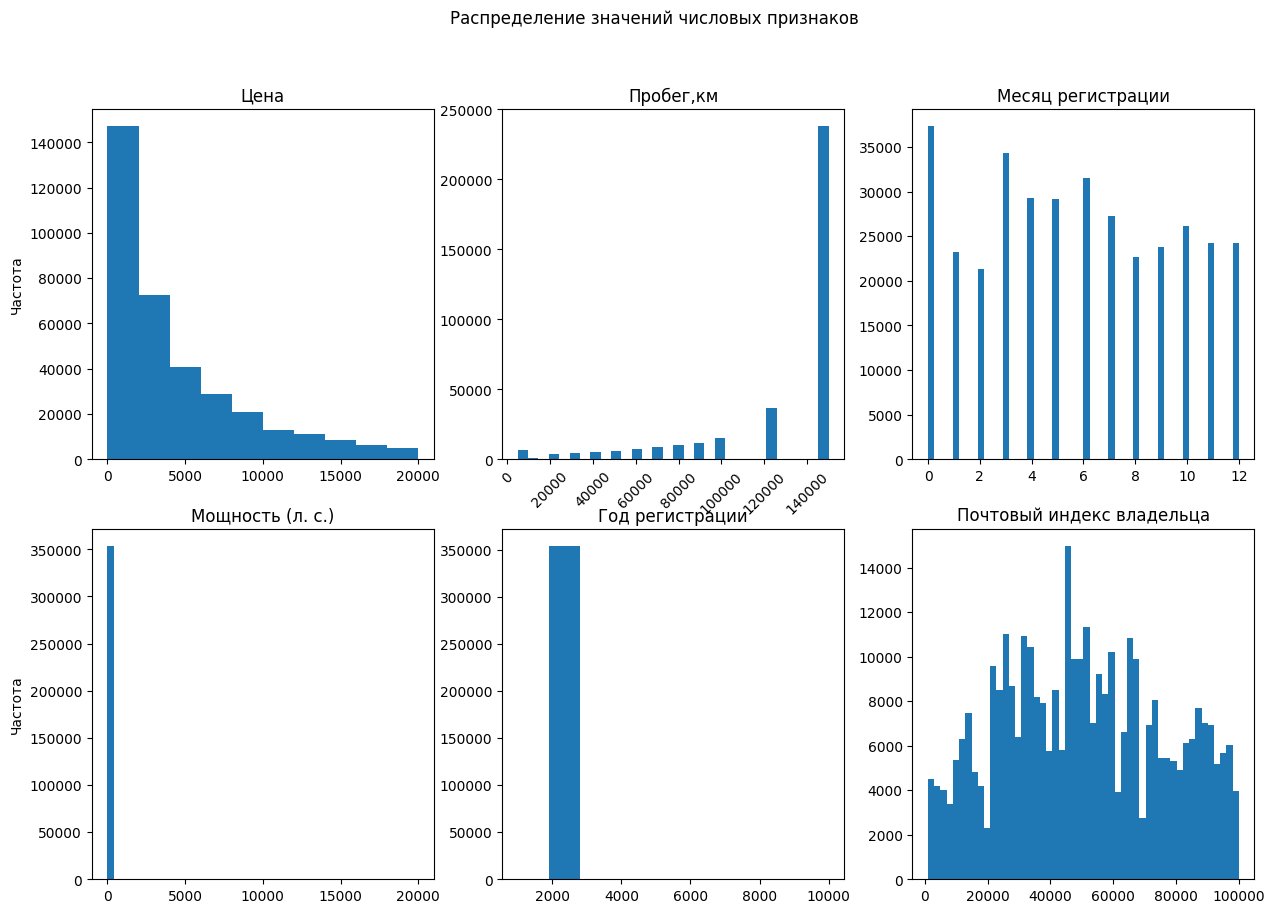

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
fig.suptitle(f'Распределение значений числовых признаков')

autos_data['Price'].plot(
ax=axes[0,0],
kind='hist',
ylabel='Частота',
title='Цена')
axes[0,0].set_ylabel('Частота')
autos_data['Kilometer'].plot(
ax=axes[0,1],
bins=30,
kind='hist',
title='Пробег,км')
axes[0,1].tick_params(axis='x', labelrotation=45)
axes[0,1].set_ylabel(' ')
autos_data['RegistrationMonth'].plot(
ax=axes[0,2],
kind='hist',
bins=50,
title='Месяц регистрации')
axes[0,2].set_ylabel(' ')
autos_data['Power'].plot(
ax=axes[1,0],
bins=50,
kind='hist',
title='Мощность (л. с.)')
axes[1,0].set_ylabel('Частота')
autos_data['RegistrationYear'].plot(
ax=axes[1,1],
kind='hist',
title='Год регистрации')
axes[1,1].set_ylabel(' ')
autos_data['PostalCode'].plot(
ax=axes[1,2],
bins=50,
kind='hist',
title='Почтовый индекс владельца')
axes[1,2].set_ylabel(' ')
plt.show()

Данные для мощности и года регистрации автомобиля содержат фантастические значения, возможно внесенные в базу данных в силу технического сбоя. Изучим их количество и распределение и избавимся от аномальных значений, если возможно

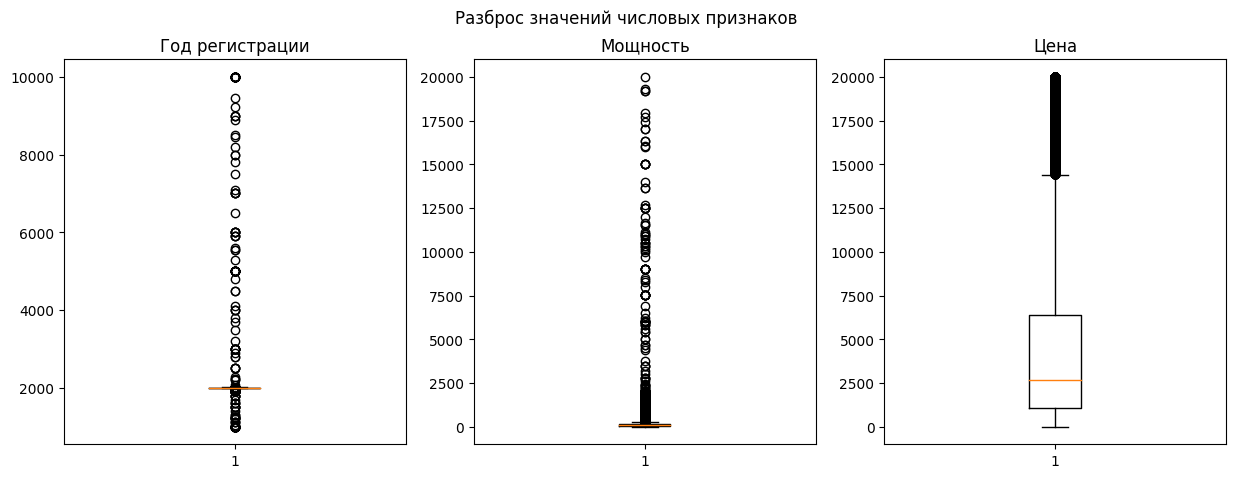

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Разброс значений числовых признаков')
axes[0].boxplot(autos_data['RegistrationYear'])
axes[1].boxplot(autos_data['Power'])
axes[2].boxplot(autos_data['Price'])
axes[0].set_title('Год регистрации')
axes[1].set_title('Мощность')
axes[2].set_title('Цена')
plt.show()

Посчитаем число значений года регистрации позднее текущего года (2024) (считаем, что машины времени не существует)

In [21]:
len(autos_data[autos_data['RegistrationYear']>2024])

105

In [22]:
def get_upper_mustache(df, char_name):
    quartiles = df[char_name].quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    return quartiles[0.75] + 1.5*iqr
def get_upper_values_cnt(df, char_name):
    upper_level= get_upper_mustache(df, char_name)
    return df[df[char_name]>upper_level][char_name].count()
def get_lower_mustache(df, char_name):
    quartiles = df[char_name].quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    return quartiles[0.25] - 1.5*iqr
def get_lower_values_cnt(df, char_name):
    lower_level= get_lower_mustache(df, char_name)
    return df[df[char_name]<lower_level][char_name].count()   

Посчитаем число значений года регистрации ранее 1.5 IQR и удалим значения ранее этой даты тк ориентация сервиса судя по заданию на массового покупателя автомобилей (с большой вероятностью дата регистрации ранее 1985 года означает ошибку в данных)

In [23]:
anomal_values_cnt=get_lower_values_cnt(autos_data, 'RegistrationYear')
lower_level_year= get_lower_mustache(autos_data, 'RegistrationYear')
print(f'Число значений записей об авто с годом регистрации ранее {lower_level_year}')
print(f'составляет {round(100*anomal_values_cnt/len(autos_data),1)}%')

Число значений записей об авто с годом регистрации ранее 1985.5
составляет 1.8%


Удалим эти значения тк количество записей составляет менее 2%

In [24]:
autos_data= autos_data[autos_data['RegistrationYear']<=2024]
autos_data= autos_data[autos_data['RegistrationYear']>=lower_level_year]

Синхронизируем год выгрузки данных из базы и дату регистрации автомобиля

In [25]:
future_reg_cnt=len(autos_data[autos_data['RegistrationYear']>pd.to_datetime(autos_data['DateCrawled']).dt.year])
print(f'Количество зарегистрированных позже даты скачивания анкеты из БД: {round(100*future_reg_cnt/len(autos_data),1)}%')

Количество зарегистрированных позже даты скачивания анкеты из БД: 4.1%


Удалим зарегистрированные позже даты скачивания анкеты из базы автомобили тк их доля в общем массиве данных не критична

In [26]:
autos_data= autos_data[autos_data['RegistrationYear']<=pd.to_datetime(autos_data['DateCrawled']).dt.year]
len(autos_data[autos_data['RegistrationYear']>pd.to_datetime(autos_data['DateCrawled']).dt.year])

0

Посчитаем число значений мощности более 1.5 IQR и удалим превышающие значения тк ориентация сервиса судя по заданию на массового покупателя автомобилей (с большой вероятностью мощность более 254 л.с. означает ошибку в данных)

In [27]:
anomal_values_cnt=get_upper_values_cnt(autos_data, 'Power')
upper_level_power= get_upper_mustache(autos_data, 'Power')
print(f'Число значений записей об авто с мощностью более {upper_level_power}')
print(f'составляет {round(100*anomal_values_cnt/len(autos_data),1)}%')

Число значений записей об авто с мощностью более 252.5
составляет 2.1%


Удалим записи о чересчур мощных автомобилях как ошибочные тк чуть более 2%

In [28]:
autos_data= autos_data[autos_data['Power']<upper_level_power]

Удалим записи об авто с нулевой мощностью 

In [29]:
autos_data= autos_data[autos_data['Power']>0]
len(autos_data[autos_data['Power']<=0])

0

Удалим записи об авто с нулевой ценой 

In [30]:
autos_data= autos_data[autos_data['Price']>0]
len(autos_data[autos_data['Price']<=0])

0

Посчитаем число значений цены более 1.5 IQR

In [31]:
anomal_values_cnt=get_upper_values_cnt(autos_data, 'Price')
upper_level_price= get_upper_mustache(autos_data, 'Price')
print(f'Число значений записей об авто с ценой более {upper_level_price}')
print(f'составляет {round(100*anomal_values_cnt/len(autos_data),1)}%')

Число значений записей об авто с ценой более 15025.0
составляет 4.2%


Количество записей об авто ценой более 1,5 IQR достаточно велико, а значение цен укладывается в представление о "премиум-сегменте". Не станем удалять еще какие-либо значения

Построим ящик с усами для мощности и года регистрации

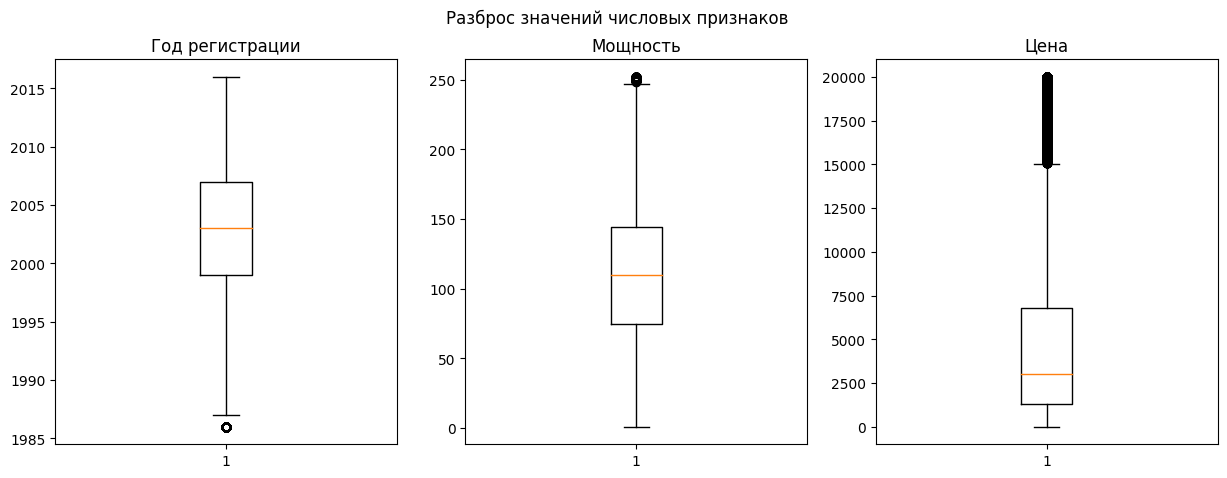

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Разброс значений числовых признаков')
axes[0].boxplot(autos_data['RegistrationYear'])
axes[1].boxplot(autos_data['Power'])
axes[2].boxplot(autos_data['Price'])
axes[0].set_title('Год регистрации')
axes[1].set_title('Мощность')
axes[2].set_title('Цена')
plt.show()

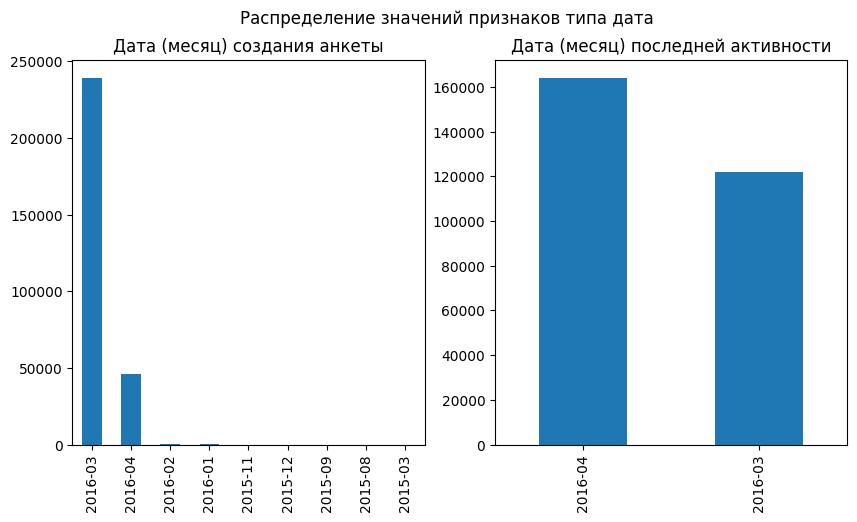

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Распределение значений признаков типа дата')
pd.to_datetime(autos_data['DateCreated']).dt.to_period('M').value_counts().plot(
ax=ax1,
kind='bar',
title='Дата (месяц) создания анкеты')
pd.to_datetime(autos_data['LastSeen']).dt.to_period('M').value_counts().plot(
ax=ax2,
kind='bar',
title='Дата (месяц) последней активности')
plt.show()

Удалим дату регистрации как неинформативную тк если бы разброс данных был бы больше, влияние на цену было бы (как минимум из-за инфляции). В нашем случае разброс совсем не велик и для модели не будет доп.информации. Дата последней активности пользователя также не помогает построить более качественную модель тк даже если она несет некий смысл в ретроспективе (например, пользователь снижал цену на свой авто чтобы сделать его более привлекательным) - это не поможет в обучении на новых данных. Дата выгрузки из базы также не информативна, удалим ее.

In [34]:
autos_data= autos_data.drop('DateCreated', axis=1)
autos_data= autos_data.drop('DateCrawled', axis=1)
autos_data= autos_data.drop('LastSeen', axis=1)

Удалим месяц постановки на учет и почтовый индекс владельца анкеты как мало информативные

In [35]:
autos_data= autos_data.drop('PostalCode', axis=1)
autos_data= autos_data.drop('RegistrationMonth', axis=1)

Проверим снова наличие явных дубликатов

In [36]:
autos_data.duplicated().sum()

39003

Удалим полные дубликаты

In [37]:
autos_data= autos_data.drop_duplicates()
autos_data.duplicated().sum()

0

Построим матрицу корреляции чтобы проверить наличие мультиколлинеарности и влияние на целевой признак

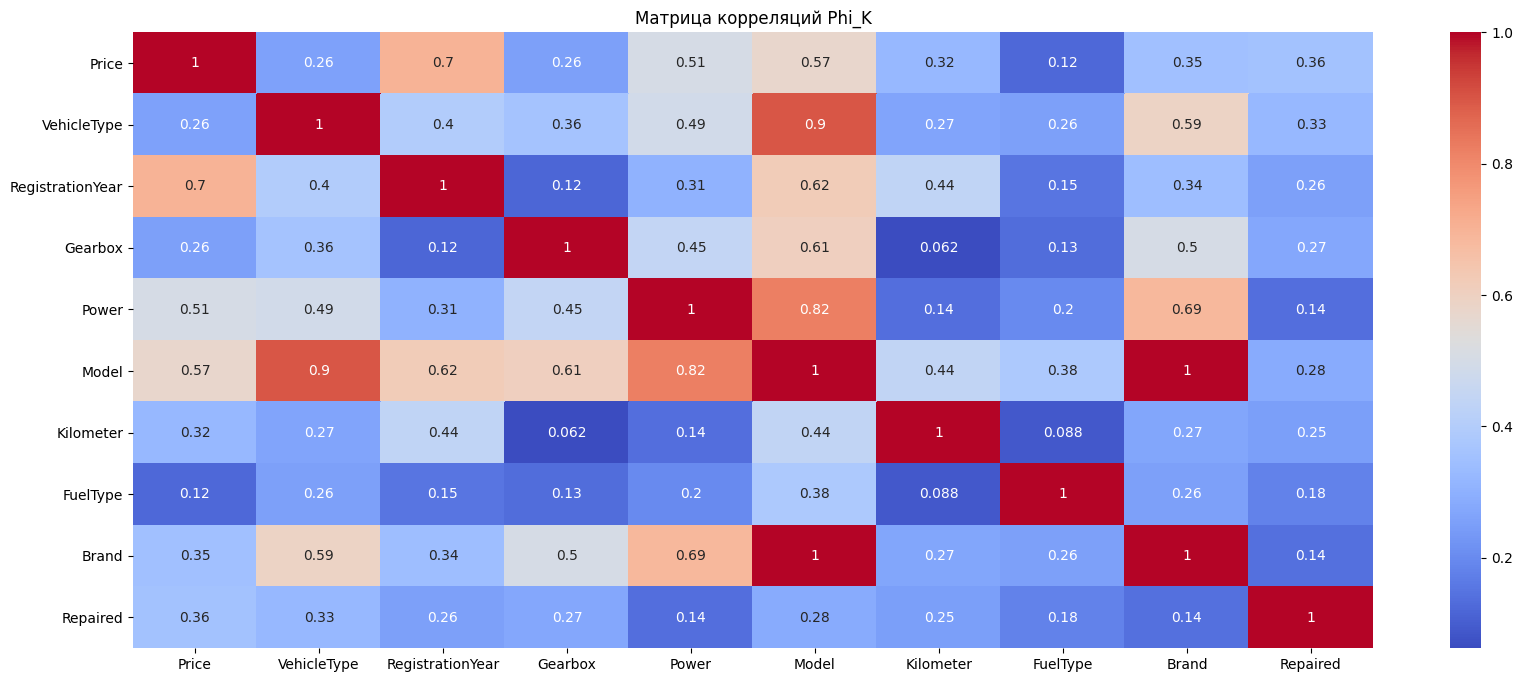

In [38]:
#матрица корреляции Phik
interval_columns=  ['Price','RegistrationYear','Power','Kilometer']
corr_matrix = autos_data.phik_matrix(interval_cols=interval_columns)

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций Phi_K')
plt.show()

Признаков мультиколлинеарности не выявлено. Среди признаков с совсем слабой корреляцией тип топлива, возможно потому, что подавляющее большинство автомобилей на рынке до сих пор на бензине.

##  2 Обучение моделей и сравнительный анализ качества, времени обучения и предсказания

#### 2.1 Разделим данные на тренировочную и тестовую выборки

In [39]:
# объявляем константу random_state
RANDOM_STATE = 77

X = autos_data.drop(columns=['Price'], axis=1)
y = autos_data['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25,
    random_state=RANDOM_STATE
)
display(X_train.head())
display(X_test.head())
display(y_train.head())
y_test.head() 

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
257069,small,2000,manual,45,clio,125000,petrol,renault,not specified
10754,convertible,1998,manual,192,z_reihe,150000,petrol,bmw,no
231690,bus,2002,manual,75,transit,150000,petrol,ford,no
288527,small,1998,auto,125,a3,150000,petrol,audi,no
83967,bus,2002,manual,125,zafira,150000,petrol,opel,not specified


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
341968,bus,2009,manual,120,doblo,150000,petrol,fiat,yes
150351,small,2004,manual,95,other,150000,petrol,fiat,yes
18124,sedan,2007,not specified,80,golf,150000,petrol,volkswagen,no
9233,small,2015,manual,95,500,10000,petrol,fiat,no
207607,small,2001,manual,60,polo,150000,petrol,volkswagen,no


257069    1300
10754     8100
231690    3250
288527    1550
83967     3000
Name: Price, dtype: int64

341968     5500
150351     1700
18124      3995
9233      12990
207607     1750
Name: Price, dtype: int64

#### 2.2 Cоздаём пайплайн для "обычных" моделей

In [40]:
ord_columns =   ['VehicleType', 
                 'Gearbox', 
                 'Model', 
                 'FuelType', 
                 'Brand', 
                 'Repaired',
                 'Kilometer',
                 'RegistrationYear']

In [41]:
создаём список численных признаков 

In [42]:
num_columns= ['Power']

In [43]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и кодирование Ordinal
ord_pipe = Pipeline(
    [
        (
            'ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
        )
    ]
)

In [44]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', [StandardScaler(), MinMaxScaler(), 'passthrough'], num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [45]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,8),
        'models__min_samples_leaf': range(2,8),
        'models__min_samples_split': range(2,8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression(
        )],
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
]


Настроим инструменты перебора гиперпараметров "обычных" моделей

In [46]:
cv_search1 = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise',
    n_iter=10
)
cv_search1.fit(X_train, y_train)
print('Лучшая модель:\n\n', cv_search1.best_estimator_)
print ('Параметры лучшей модели:', cv_search1.best_params_)
print ('Метрика RMSE лучшей модели на кросс-валидации:', round(-1*cv_search1.best_score_,2))

Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired', 'Kilometer',
                                                   'RegistrationYear']),
                                                 ('num', 'passthrough',
                                                  ['Power'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=7, min_samples_l

#### 2.2.1 Замеряем время обучения лучшей модели (не градиентный бустинг)

In [47]:
start_train_first_best_model = time()

cv_search1.best_estimator_.fit(X_train, y_train)

end_train_first_best_model = time()

train_first_model_time = (end_train_first_best_model-start_train_first_best_model)
print(f'Время обучения лучшей модели (не градиентный бустинг): {round(train_first_model_time,2)} с')

Время обучения лучшей модели (не градиентный бустинг): 0.77 с


#### 2.2.2 Замеряем время предсказания лучшей модели на тренировочной выборке

In [48]:
start_predict_first_best_model = time()
cv_search1.best_estimator_.predict(X_train)
end_predict_first_best_model = time()
predict_first_model_time = (end_predict_first_best_model-start_predict_first_best_model)
print(f'Время предсказания лучшей модели (не градиентный бустинг): {round(predict_first_model_time,2)} с')

Время предсказания лучшей модели (не градиентный бустинг): 0.38 с


#### 2.3 Создаем пайплайн для модели LGBMRegressor

In [49]:
param_grid= (
    #словарь для модели LGBMRegressor
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__num_leaves': range(4,32),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
)    

In [50]:
cv_search2 = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise',
    n_iter=10
)
cv_search2.fit(X_train, y_train)
print('Лучшая модель:\n\n', cv_search2.best_estimator_)
print ('Параметры лучшей модели:', cv_search2.best_params_)
print ('Метрика RMSE лучшей модели на тренировочной выборке:', round(-1*cv_search2.best_score_,2))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 185196, number of used features: 9
[LightGBM] [Info] Start training from score 4770.870256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

#### 2.3.1 Замеряем время обучения лучшей модели (градиентный бустинг)

In [51]:
start_train_second_best_model = time()

cv_search2.best_estimator_.fit(X_train, y_train)

end_train_second_best_model = time()

train_second_model_time = (end_train_second_best_model-start_train_second_best_model)
print(f'Время обучения лучшей модели (градиентный бустинг): {round(train_second_model_time,2)} с')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 185196, number of used features: 9
[LightGBM] [Info] Start training from score 4770.870256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

#### 2.3.2 Замеряем время предсказания лучшей модели на тренировочной выборке (градиентный бустинг)

In [52]:
start_predict_second_best_model = time()
cv_search2.best_estimator_.predict(X_train)
end_predict_second_best_model = time()
predict_second_model_time = (end_predict_second_best_model-start_predict_second_best_model)
print(f'Время предсказания лучшей модели (градиентный бустинг): {round(predict_second_model_time,2)} с')

Время предсказания лучшей модели (градиентный бустинг): 0.97 с


#### 2.4 Обучим и сделаем предсказание с помощью константной модели DummyRegressor

In [53]:
dummy_model= DummyRegressor()
start_train_dummy_model = time()
dummy_model.fit(X_train, y_train)
end_train_dummy_model = time()
train_dummy_model_time = (end_train_dummy_model-start_train_dummy_model)
start_predict_dummy_model = time()
dummy_pred= dummy_model.predict(X_train)
end_predict_dummy_model = time()
predict_dummy_model_time = (end_predict_dummy_model-start_predict_dummy_model)
dummy_rmse= root_mean_squared_error(y_train.tolist(), dummy_pred) 
dummy_rmse

4531.83505914986

#### 2.5 Сравнение моделей

In [54]:
data = [
    {
     "Модель": cv_search1.best_params_['models'], 
     "Время обучения": round(train_first_model_time,2),
     "Время предсказания": round(predict_first_model_time,2),
     "Точность результата (RMSE)": round(-1*cv_search1.best_score_,2)
    },
    {
    "Модель": cv_search2.best_params_['models'], 
     "Время обучения": round(train_second_model_time,2),
     "Время предсказания": round(predict_second_model_time,2),
     "Точность результата (RMSE)": round(-1*cv_search2.best_score_,2)
     },
     {
    "Модель": 'DummyRegressor', 
     "Время обучения": round(train_dummy_model_time,2),
     "Время предсказания": round(predict_dummy_model_time,2),
     "Точность результата (RMSE)": round(dummy_rmse,2)
     }   
]
df_result= pd.DataFrame.from_records(data)
print('Сравнительная таблица характеристик моделей')
df_result

Сравнительная таблица характеристик моделей


,Модель,Время обучения,Время предсказания,Точность результата (RMSE)
0,DecisionTreeRegressor(random_state=77),0.77,0.38,2072.12
1,LGBMRegressor(random_state=77),1.27,0.97,1696.50
2,DummyRegressor,0.01,0.00,4531.84


**Вывод: однозначно выбрать лучшую модель нельзя, тк по скорости выигрывает DecisionTreeRegressor, а по качеству LGBMRegressor. Я бы выбрал LGBMRegressor тк приращение в скорости в абсолютном отношении не превышает 1 секунды на заданном объеме данных, а качество у модели значительно выше. При этом еще возможно улучшить показатели (возможно, и производительность) модели, если применить собственное кодирование категориальных признаков LGBMRegressor вместо OrdinalEncoder.**

In [55]:
best_model= cv_search2.best_estimator_

#### 2.6 Проверим качество лучшей выбранной модели на тестовой выборке

In [56]:
y_pred= best_model.predict(X_test)
RMSE = root_mean_squared_error(y_test.tolist(), y_pred) 
print(f'Метрика RMSE лучшей модели на тестовой выборке: {round(RMSE,2)}')

Метрика RMSE лучшей модели на тестовой выборке: 1714.18


# Общий вывод

**В результате работы рассмотрены "обычные" модели регрессии (DecisionTreeRegressor, LinearRegression, и DummyRegressor для сравнения с константной моделью) и модель градиентного бустинга для задачи регресии LGBMRegressor с подбором гиперпараметров в pipeline. Лучший результат по метрике RMSE показала модель LGBMRegressor (RMSE= 1696.5 на тренировочной выборке), она может быть выбрана в качестве лучшей модели по критерию качества. Метрика качества на тестовой выборке RMSE составляет 1714.18**